In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from obspy.taup import TauPyModel
from obspy.geodetics import degrees2kilometers, kilometer2degrees, gps2dist_azimuth
from mudpy import fakequakes
from matplotlib.lines import Line2D
import matplotlib as mpl 
import matplotlib.colors as colors
from matplotlib.colors import Normalize

In [2]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [3]:
path = '/Users/sydneydybing/SW4/strain/experiments/'
results_path = path + 'talapas/results/homogeneous/'
plot_save_path = path + 'results_plots/'

dirs_list = sorted((f for f in os.listdir(results_path) if not f.startswith('.')), key = str.lower)
print(dirs_list)

models = ['MH2017', 'MH2017-1', 'MH2017+1']

events = pd.read_csv(path + 'homo_events.csv')
rupt_patterns_only = events.iloc[[0,3,6,9]]
rupt_patterns_only

['large_slip_area_1', 'medium_slip_area_2', 'small_slip_area_3', 'surface_slip_area_4']


,rupt_num,longitude,latitude,depth,rise_time
0,2,-117.622955,35.777562,14.58,2.8
3,3,-118.049495,36.180743,10.10,2.8
6,1,-117.583453,35.745836,10.10,2.8
9,4,-117.657729,35.824579,2.63,2.8


In [11]:
sta_file = 'bsm_metadata.csv'
real_strain_stas = pd.read_csv(path + sta_file)
# Choose subset of stations
rc_stas = ['B072', 'B073', 'B075', 'B076', 'B078', 'B079', 'B081', 'B082', 'B084', 'B086', 'B087', 'B088', 'B089', 'B900', 'B901', 'B916', 'B917', 'B918', 'B921', 'B946'] # close to Ridgecrest
# rc_stas_sub = ['B072', 'B079', 'B082', 'B087', 'B916', 'B917', 'B918', 'B921'] # subset of stations close to Ridgecrest - 4 super close, 2 west, 2 south
rc_stas_sub = ['B916', 'B917', 'B918', 'B921']
real_strain_stas_sub = real_strain_stas.query('BNUM in @rc_stas_sub').reset_index(drop = True)
real_strain_stas_sub

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),DATA_START,->,DATA_END,GAP(m),L_DATE,L0(cnts),L1(cnts),L2(cnts),L3(cnts),REGION
0,B916,marips916bcs2008,36.1925,-117.6685,1859.9,3/13/08,303.6,176.5,166.9,NaN,2008:073,->,Present,0.0001,2008:090,55948375,53191200,55522127,49391430,Mojave_California
1,B917,tonyso917bcs2008,35.3892,-117.2587,1125.9,7/14/08,306.1,162.5,Unknown,NaN,2008:196,->,Present,0.0001,2008:219,51200216,53318503,50164819,49964400,Mojave_California
2,B918,mtsprn918bcs2008,35.9357,-117.6017,1042.6,6/21/08,288.9,196.7,189.9,NaN,2008:173,->,Present,0.0001,2008:245,56324863,55262353,53608304,55388642,Mojave_California
3,B921,randsb921bcs2008,35.5865,-117.4622,694.5,6/3/08,340.5,147.4,139.9,NaN,2008:157,->,Present,0.0001,2008:178,53324139,53302937,55141972,53475662,Mojave_California


In [24]:
extra_stas = pd.read_csv(path + 'extra_stas_w_travel_times_azimuths_azgroups.csv')
# Pick a few stations
extra_stas_sub = extra_stas.iloc[[0,5,10,25,29,55,60,65,80,84,110,115,120]]
extra_stas_sub

,name,lon,lat,medium_slip_area_2_hypo_dist_km,medium_slip_area_2_p_arrival,medium_slip_area_2_azs,small_slip_area_3_hypo_dist_km,small_slip_area_3_p_arrival,small_slip_area_3_azs,large_slip_area_1_hypo_dist_km,large_slip_area_1_p_arrival,large_slip_area_1_azs,surface_slip_area_4_hypo_dist_km,surface_slip_area_4_p_arrival,surface_slip_area_4_azs,medium_slip_area_2_az_group,small_slip_area_3_az_group,large_slip_area_1_az_group,surface_slip_area_4_az_group
0,E1,-119.00,34.50,189.305303,28.691339,221.920311,205.517271,31.132456,205.138544,189.140065,29.123696,223.460773,191.176748,30.201185,220.154825,45-90,90-135,45-90,90-135
5,E6,-119.00,35.75,124.565187,20.109641,268.995717,98.159352,16.319835,241.142450,128.126053,20.905277,270.620394,121.629113,20.373970,266.491611,0-45,45-90,0-45,0-45
10,E11,-119.00,37.00,183.474434,27.976150,318.079865,124.497360,20.368251,317.188156,188.480534,29.042801,318.009559,177.496699,28.523248,317.689185,-45-0,-45-0,-45-0,-45-0
25,E26,-118.50,35.25,98.771345,16.250082,233.913176,111.023570,18.316456,201.672980,99.708702,16.564550,236.780878,99.490208,16.818911,230.396939,45-90,90-135,45-90,45-90
29,E30,-118.50,36.25,94.862842,15.654893,303.802662,41.230941,7.275288,280.875102,99.794262,16.578064,304.363506,89.386597,15.177674,302.123817,0-45,0-45,0-45,0-45
55,E56,-117.75,34.50,142.208789,22.695597,184.706627,188.449961,29.039051,171.606097,139.047708,22.506022,186.315987,147.193748,24.266755,183.300722,90-135,135-180,90-135,90-135
60,E61,-117.75,35.75,11.888952,3.251115,255.131687,54.901173,9.475945,150.435079,15.071217,3.212807,271.805348,11.749872,2.406785,225.257525,45-90,135-180,0-45,45-90
65,E66,-117.75,37.00,136.127346,21.804263,355.234425,94.780885,15.786217,16.336264,139.969606,22.641142,353.919736,130.694826,21.784709,356.396762,-45-0,270-315,-45-0,-90--45
80,E81,-117.25,35.25,67.607022,11.487626,149.863501,126.086637,20.606367,144.753425,62.783367,10.732311,151.094095,73.696831,12.629019,149.766882,135-180,135-180,135-180,135-180
84,E85,-117.25,36.25,62.276509,10.650699,32.565143,72.298287,12.235163,83.662138,63.509134,10.846944,28.158252,59.820167,10.374884,37.778179,270-315,225-270,270-315,270-315


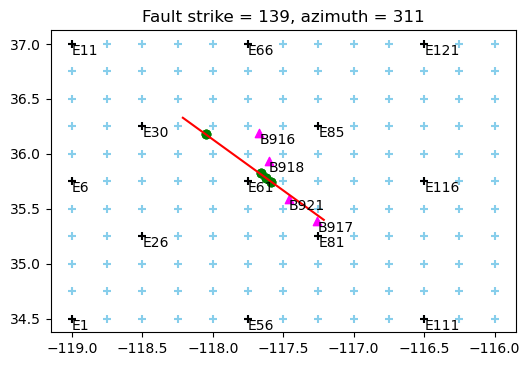

In [25]:
# Fault extent
min_lon = -118.2123
max_lon = -117.2121
min_lat = 35.3989
max_lat = 36.3284

plt.figure(dpi = 100)

plt.title('Fault strike = 139, azimuth = 311')

plt.plot([min_lon, max_lon], [max_lat, min_lat], color = 'red', label = 'Planar fault extent')   

plt.scatter(real_strain_stas_sub['LONG'], real_strain_stas_sub['LAT'], marker = '^', color = 'magenta', label = 'Real BSM stations')
plt.scatter(extra_stas['lon'], extra_stas['lat'], marker = '+', color = 'skyblue', label = 'Extra stations')
plt.scatter(extra_stas_sub['lon'], extra_stas_sub['lat'], marker = '+', color = 'black', label = 'Extra stations')
plt.scatter(events['longitude'], events['latitude'], color = 'green')

[plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(real_strain_stas_sub['LONG'], real_strain_stas_sub['LAT'], real_strain_stas_sub['BNUM'])];
[plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(extra_stas_sub['lon'], extra_stas_sub['lat'], extra_stas_sub['name'])];
# [plt.text(i, j, f'{name}', va = 'top', ha = 'left') for (i, j, name) in zip(stas_sub['lon'], stas_sub['lat']-0.1, stas_sub['medium_slip_area_2_azs'].astype(int))];



In [32]:
# Calculate theoretical P-wave arrival times for the BSM stations

# Make or load our custom TauPyModel format velocity model
custom_model = TauPyModel(model = path + 'mojave_simpletop_forsw4.npz')

# Add a column to the stations dataframe with the theoretical P-wave arrival times

for idx in range(len(rupt_patterns_only)):
    
    dists_km = []
    p_arr_times = []
    azs = []
    
    rupt_num = rupt_patterns_only['rupt_num'].values[idx]
    hypo_lat = rupt_patterns_only['latitude'].values[idx]
    hypo_lon = rupt_patterns_only['longitude'].values[idx]
    hypo_depth = rupt_patterns_only['depth'].values[idx] # km
    
    print(idx, rupt_num)
    # print(hypo_lat, hypo_lon, hypo_depth)

    for idx2 in range(len(real_strain_stas)):

        sta_lat = real_strain_stas['LAT'].values[idx2]
        sta_lon = real_strain_stas['LONG'].values[idx2]
        
        # print(sta_lat, sta_lon)

        dist_m, az, baz = gps2dist_azimuth(hypo_lat, hypo_lon, sta_lat, sta_lon) # dist in meters, az is angle in degrees from hypo to sta
        # print(round(dist_m/1000,1))

        arrivals = custom_model.get_travel_times(source_depth_in_km = hypo_depth, 
                                      distance_in_degree = kilometer2degrees(dist_m/1000), phase_list=['p', 'P'])
        p_arr_time = arrivals[0].time

        p_arr_times.append(p_arr_time)
        dists_km.append(dist_m/1000)
        azs.append(az)

    if idx == 0:
        # Rupt num 2
        real_strain_stas['medium_slip_area_2_hypo_dist_km'] = dists_km
        real_strain_stas['medium_slip_area_2_p_arrival'] = p_arr_times
        real_strain_stas['medium_slip_area_2_azs'] = azs
    elif idx == 1:
        # Rupt num 3
        real_strain_stas['small_slip_area_3_hypo_dist_km'] = dists_km
        real_strain_stas['small_slip_area_3_p_arrival'] = p_arr_times
        real_strain_stas['small_slip_area_3_azs'] = azs
    elif idx == 2:
        # Rupt num 1
        real_strain_stas['large_slip_area_1_hypo_dist_km'] = dists_km
        real_strain_stas['large_slip_area_1_p_arrival'] = p_arr_times
        real_strain_stas['large_slip_area_1_azs'] = azs
    elif idx == 3:
        # Rupt num 4
        real_strain_stas['surface_slip_area_4_hypo_dist_km'] = dists_km
        real_strain_stas['surface_slip_area_4_p_arrival'] = p_arr_times
        real_strain_stas['surface_slip_area_4_azs'] = azs

0 2
1 3
2 1
3 4


In [33]:
# Group subset by location/azimuth

fault_az = 311

for idx in range(len(rupt_patterns_only)):
    rupt = rupt_patterns_only['rupt_num'].values[idx]
    print(rupt)
    if idx == 0:
        rupt_name = 'medium_slip_area_2'
    elif idx == 1:
        rupt_name = 'small_slip_area_3'
    elif idx == 2:
        rupt_name = 'large_slip_area_1'
    elif idx == 3:
        rupt_name = 'surface_slip_area_4'
    
    groups = []
    az_diffs = []
    
    for i in range(len(real_strain_stas)):
        
        # print(extra_stas['name'].values[i])
        sta_az = real_strain_stas[rupt_name + '_azs'].values[i]
        az_diff = fault_az - sta_az
        # print(int(sta_az), int(az_diff))
        az_diffs.append(az_diff)
        # print(az_diff)
        
        if -90 < az_diff <= -45:
            groups.append('-90--45')
            print('this one')
        elif -45 < az_diff <= 0:
            groups.append('-45-0')
        elif 0 < az_diff <= 45:
            groups.append('0-45')
        elif 45 < az_diff <= 90:
            groups.append('45-90')
        elif 90 < az_diff <= 135:
            groups.append('90-135')
        elif 135 < az_diff <= 180:
            groups.append('135-180')
        elif 180 < az_diff <= 225:
            groups.append('180-225')
        elif 225 < az_diff <= 270:
            groups.append('225-270')
        elif 270 < az_diff <= 315:
            groups.append('270-315')
        elif 315 < az_diff <= 360:
            groups.append('315-360')
    
    real_strain_stas[rupt_name + '_az_group'] = groups

2
3
1
4
this one


In [34]:
real_strain_stas

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),...,large_slip_area_1_hypo_dist_km,large_slip_area_1_p_arrival,large_slip_area_1_azs,surface_slip_area_4_hypo_dist_km,surface_slip_area_4_p_arrival,surface_slip_area_4_azs,medium_slip_area_2_az_group,small_slip_area_3_az_group,large_slip_area_1_az_group,surface_slip_area_4_az_group
0,AVN2,osageavn2bok2016,36.532120,-96.081020,261.0,9/10/16,230.5,96.0,NaN,NaN,...,1933.277016,241.171685,81.059497,1938.572482,242.675464,81.293213,225-270,225-270,225-270,225-270
1,B001,golbeck01bwa2005,48.043070,-123.131410,237.0,6/29/05,200.2,152.9,144.4,20.6,...,1440.391903,182.526543,343.189971,1430.090048,182.093829,343.300033,-45-0,-45-0,-45-0,-45-0
2,B003,floequarybwa2005,48.062360,-124.140860,284.7,6/21/05,250.7,169.8,159.7,50.3,...,1470.873576,186.259867,340.456377,1460.396238,185.805818,340.544028,-45-0,-45-0,-45-0,-45-0
3,B004,hokofallsbwa2005,48.201930,-124.427010,30.0,6/15/05,168.2,166.1,156.1,3.4,...,1493.784180,189.065732,339.948400,1483.276828,188.608129,340.030427,-45-0,-45-0,-45-0,-45-0
4,B005,shoresnw1bwa2005,48.059550,-123.503280,302.7,7/19/05,319.7,161.2,153,44.5,...,1452.111505,183.961963,342.183349,1441.742254,183.521055,342.285033,-45-0,-45-0,-45-0,-45-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,TSM2,tstartsm2bit2021,43.396190,12.489944,630.0,11/3/21,345.4,158.1,152.5,NaN,...,9892.287080,773.748936,33.772271,9888.753587,774.795644,33.730838,270-315,270-315,270-315,270-315
85,TSM3,tstartsm3bit2021,43.382980,12.354506,341.0,11/15/21,312.1,78.6,73,NaN,...,9886.619475,773.510118,33.857610,9883.101539,774.557126,33.816260,270-315,270-315,270-315,270-315
86,TSM4,tstartsm4bit2022,43.308700,12.304600,270.0,5/14/22,Unknown,99.3,95.1,NaN,...,9890.563160,773.676273,33.932103,9887.058799,774.724146,33.890696,270-315,270-315,270-315,270-315
87,TSM5,tstartsm5bit2022,43.479691,12.602520,379.0,5/27/22,342.9,116.0,111,NaN,...,9890.661218,773.680406,33.656496,9887.106644,774.726165,33.615086,270-315,270-315,270-315,270-315


In [35]:
real_strain_stas.to_csv(path + 'real_strain_stas_w_travel_times_azimuths_azgroups.csv', index = False)

In [36]:
# Compare real, Dara's model, and experiment strain station records

real_strain_stas_sub = real_strain_stas.query('BNUM in @rc_stas_sub').reset_index(drop = True)
real_strain_stas_sub

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),...,large_slip_area_1_hypo_dist_km,large_slip_area_1_p_arrival,large_slip_area_1_azs,surface_slip_area_4_hypo_dist_km,surface_slip_area_4_p_arrival,surface_slip_area_4_azs,medium_slip_area_2_az_group,small_slip_area_3_az_group,large_slip_area_1_az_group,surface_slip_area_4_az_group
0,B916,marips916bcs2008,36.1925,-117.6685,1859.9,3/13/08,303.6,176.5,166.9,NaN,...,50.151289,8.709992,351.226460,40.835752,7.251548,358.640578,-45-0,180-225,-45-0,-90--45
1,B917,tonyso917bcs2008,35.3892,-117.2587,1125.9,7/14/08,306.1,162.5,Unknown,NaN,...,49.319561,8.575922,143.255686,60.338105,10.458540,143.069908,135-180,135-180,135-180,135-180
2,B918,mtsprn918bcs2008,35.9357,-117.6017,1042.6,6/21/08,288.9,196.7,189.9,NaN,...,21.130962,4.107419,355.530902,13.327317,2.668977,22.294188,270-315,180-225,-45-0,270-315
3,B921,randsb921bcs2008,35.5865,-117.4622,694.5,6/3/08,340.5,147.4,139.9,NaN,...,20.810254,4.058711,148.124385,31.794634,5.745410,146.126211,135-180,135-180,135-180,135-180


In [43]:
dara_p_arrivals = pd.read_csv('/Users/sydneydybing/SW4/strain/sw4_strain_stations_metadata.csv').query('BNUM in @rc_stas_sub').reset_index(drop = True)
dara_p_arrivals

,BNUM,NAME,LAT,LONG,ELEV(m),INSTALL_DATE,CH0(EofN),BSM_Depth(m),SEISMOMETER_Depth(m),PORE_DEPTH(m),...,DATA_END,GAP(m),L_DATE,L0(cnts),L1(cnts),L2(cnts),L3(cnts),REGION,hypo_dist_km,p_arrival
0,B916,marips916bcs2008,36.1925,-117.6685,1859.9,3/13/08,303.6,176.5,166.9,NaN,...,Present,0.0001,2008:090,55948375,53191200,55522127,49391430,Mojave_California,47.348199,8.224188
1,B917,tonyso917bcs2008,35.3892,-117.2587,1125.9,7/14/08,306.1,162.5,Unknown,NaN,...,Present,0.0001,2008:219,51200216,53318503,50164819,49964400,Mojave_California,52.284362,9.024224
2,B918,mtsprn918bcs2008,35.9357,-117.6017,1042.6,6/21/08,288.9,196.7,189.9,NaN,...,Present,0.0001,2008:245,56324863,55262353,53608304,55388642,Mojave_California,18.442171,3.584549
3,B921,randsb921bcs2008,35.5865,-117.4622,694.5,6/3/08,340.5,147.4,139.9,NaN,...,Present,0.0001,2008:178,53324139,53302937,55141972,53475662,Mojave_California,23.798922,4.428801


In [74]:
# Make station_plots_w_each_rise_time
   
for i in range(len(real_strain_stas_sub)):

    sta = real_strain_stas_sub['BNUM'].values[i]
    
    

    print(sta)
    # print(theo_p_arr)
    # print(dara_theo_p_arr)
    # print(hypo_dist)

    # Load and process data from Dara's rupture model

    dara_strain = np.load('/Users/sydneydybing/SW4/strain/rms_and_peak_sw4_data/strain/peak/' + real_strain_stas_sub['BNUM'].values[i] + '.npy')
    # print(dara_strain)
    dara_time_strain = dara_strain[:,0]
    dara_peak_strain = dara_strain[:,1]
    
    # Move the flat line at the beginning of each timeseries to the same level

    dara_norm_strain = np.copy(dara_peak_strain)
    dara_norm_level = dara_peak_strain[0]
    dara_norm_strain = dara_norm_strain - dara_norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

    dara_theo_p_arr = dara_p_arrivals['p_arrival'].values[i]

    for rupt in dirs_list:

        rupt_path = results_path + rupt + '/'
        print(rupt)
        
        theo_p_arr = real_strain_stas_sub[rupt + '_p_arrival'].values[i]
        hypo_dist = real_strain_stas_sub[rupt + '_hypo_dist_km'].values[i]
        az_diff = real_strain_stas_sub[rupt + '_azs'].values[i]

        plt.figure(dpi = 300, facecolor = 'white')

        for model in models:

            model_path = rupt_path + model + '/results/'
            # print(model_path)

            strain_path = model_path + real_strain_stas_sub['BNUM'].values[i] + 's.txt'
            disp_path = model_path + real_strain_stas_sub['BNUM'].values[i] + 'd.txt'

            ### Process strain data ###

            time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain = process_strain(strain_path, theo_p_arr)
            time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss = process_disp(disp_path, theo_p_arr)

            # Move the flat line at the beginning of each timeseries to the same level

            norm_strain = np.copy(peak_strain)
            norm_level = peak_strain[0]
            norm_strain = norm_strain - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

            if model == 'MH2017':
                rise_time = 2.8
                color = 'orange'
            elif model == 'MH2017-1':
                rise_time = 1.8
                color = 'red'
            elif model == 'MH2017+1':
                rise_time = 3.8
                color = 'green'
                
            # Shift to align P-arrivals
            
            if theo_p_arr >= dara_theo_p_arr: # Shift the strain backward
                shift_amount = theo_p_arr - dara_theo_p_arr
                time_strain = time_strain - shift_amount
            else: # Shift the strain forward
                shift_amount = dara_theo_p_arr - theo_p_arr
                time_strain = time_strain + shift_amount
            
            # Plot

            plt.title(rupt + ', station ' + sta + '\nHyp. dist = ' + str(int(hypo_dist)) + 'km, az. diff = ' + str(int(az_diff)) + '$^{\circ}$')
            plt.plot(time_strain, norm_strain, color = color, label = 'Homogenous model:\n' + str(rise_time) + 's rise time')
            # plt.axvline(theo_p_arr, color = 'gray', linestyle = '--')

        plt.plot(dara_time_strain, dara_norm_strain, color = 'blue', label = "Dara's model")
        plt.axvline(dara_theo_p_arr, color = 'gray', linestyle = '--', label = 'P-wave arrival') 
        plt.xlabel('Time (s)')
        plt.ylabel('Relative peak strain')
        plt.xlim(dara_theo_p_arr-2, dara_theo_p_arr+15)
        plt.semilogy()
        plt.legend()

        # plt.show()

        # Create folder for the event
        fig_save_dir = plot_save_path + 'dara_model_vs_homo_models/' + rupt + '/'
        # print(fig_save_dir)
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)
        plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
        plt.close()


B916
large_slip_area_1
medium_slip_area_2
small_slip_area_3
surface_slip_area_4
B917
large_slip_area_1
medium_slip_area_2
small_slip_area_3
surface_slip_area_4
B918
large_slip_area_1
medium_slip_area_2
small_slip_area_3
surface_slip_area_4
B921
large_slip_area_1
medium_slip_area_2
small_slip_area_3
surface_slip_area_4


In [37]:
### Process strain data ###

def process_strain(strain_data, theoretical_p_arrival):
    
    strain = pd.read_csv(strain_path, sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])

    # Calculate horizontal RMS strain
    time_strain = strain.time.values
    xx_strain = strain.xx.values
    xy_strain = strain.xy.values
    yy_strain = strain.yy.values
    rms_strain = np.sqrt((xx_strain**2 + xy_strain**2 + yy_strain**2)/3)

    # Calculate peak strain
    strain_p_i = np.abs(time_strain - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_strain = rms_strain.copy()
    p_arr_strain = rms_strain[strain_p_i]
    mod_rms_strain[:strain_p_i] = p_arr_strain # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_strain = mod_rms_strain.copy()
    for k in range(0,len(mod_rms_strain)):
        if k == 0:
            strain = mod_rms_strain[0]
            max_strain = strain
        else:
            # Grab progressively longer windows and save the biggest strain
            strain = mod_rms_strain[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)
        # Put peak strain back into the output stream
        peak_strain[k] = max_strain 
    
    return time_strain, xx_strain, xy_strain, yy_strain, rms_strain, peak_strain

### Process GNSS data to match the strain processing ###

def process_disp(disp_data, theoretical_p_arrival):
    
    disp = pd.read_csv(disp_path, sep = '\s+', skiprows = 13, names = ['time', 'x', 'y', 'z'])

    # Calculate horizontal RMS GNSS  
    time_gnss = disp.time.values
    x_gnss = disp.x.values
    y_gnss = disp.y.values
    rms_gnss = np.sqrt((x_gnss**2 + y_gnss**2)/2)

    # Calculate peak GNSS
    gnss_p_i = np.abs(time_gnss - theo_p_arr).argmin() # Get the index where the P-wave arrives
    mod_rms_gnss = rms_gnss.copy()
    p_arr_gnss = rms_gnss[gnss_p_i]
    mod_rms_gnss[:gnss_p_i] = p_arr_gnss # Strain before the P wave is set to be the same as the strain AT the P wave
    peak_gnss = mod_rms_gnss.copy()
    for k in range(0,len(mod_rms_gnss)):
        if k == 0:
            gnss = mod_rms_gnss[0]
            max_gnss = gnss
        else:
            # Grab progressively longer windows and save the biggest strain
            gnss = mod_rms_gnss[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_gnss = max(gnss)
        # Put peak strain back into the output stream
        peak_gnss[k] = max_gnss 
    
    return time_gnss, x_gnss, y_gnss, rms_gnss, peak_gnss